# Data Preprocess

In [1]:
!unzip /content/train_data.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: train_data/rec/train/r02-089-05.png  
  inflating: __MACOSX/train_data/rec/train/._r02-089-05.png  
  inflating: train_data/rec/train/g04-088-02.png  
  inflating: __MACOSX/train_data/rec/train/._g04-088-02.png  
  inflating: train_data/rec/train/p03-072-01.png  
  inflating: __MACOSX/train_data/rec/train/._p03-072-01.png  
  inflating: train_data/rec/train/n04-068-06.png  
  inflating: __MACOSX/train_data/rec/train/._n04-068-06.png  
  inflating: train_data/rec/train/m04-180-01.png  
  inflating: __MACOSX/train_data/rec/train/._m04-180-01.png  
  inflating: train_data/rec/train/j04-012-07.png  
  inflating: __MACOSX/train_data/rec/train/._j04-012-07.png  
  inflating: train_data/rec/train/k04-000-00.png  
  inflating: __MACOSX/train_data/rec/train/._k04-000-00.png  
  inflating: train_data/rec/train/c04-170-00.png  
  inflating: __MACOSX/train_data/rec/train/._c04-170-00.png  
  inflating: train_data/rec/train/a05-009-07.png  
  inflating: __MAC

# Train

In [1]:
from __future__ import annotations

import argparse
import math
import os
from pathlib import Path
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

In [8]:
# CHANGE BEFORE TRAINING!!!!
data_root = "./"  # path to train_data, the path should not include the directory name 'train_data'
label_file = "./train_data/rec/rec_gt_train.txt"
val_file = "./train_data/rec/rec_gt_test.txt"
num_samples = 64 # number of samples used for validation during training
epochs = 50
batch_size = 30
lr = 1e-3
# save_path = "/content/crnn_ctc_pytorch.pth"
save_path = "./crnn_ctc_pytorch_best.pth"


In [3]:
# -------------------------
# Dataset & preprocessing
# -------------------------
class HandwritingDataset(Dataset):
    """Loads (image, transcription) pairs listed in a TSV file.

    Each line in *label_file* should be:  <img_rel_path>\t<label>\n
    Images are resized to fixed *target_height* while preserving aspect ratio.
    """

    def __init__(
        self,
        data_root: str | Path,
        label_file: str | Path,
        char2idx: dict[str, int],
        target_height: int = 64,
    ) -> None:
        super().__init__()
        self.data_root = Path(data_root)
        self.samples: List[Tuple[Path, str]] = []
        with open(label_file, "r", encoding="utf-8") as f:
            for line in f:
                img_rel, label = line.rstrip("\n").split("\t", 1)
                self.samples.append((self.data_root / img_rel, label))
        self.char2idx = char2idx
        self.blank_idx = len(char2idx)  # final slot reserved for blank
        self.to_tensor = transforms.ToTensor()  # converts HWC [0,255] -> CHW [0,1]
        self.target_height = target_height

    def _text_to_indices(self, text: str) -> List[int]:
        # Replace '|' with space (same logic as TF script)
        return [self.char2idx.get(ch, self.blank_idx) for ch in text.replace("|", " ")]

    def _resize_keep_ratio(self, img: Image.Image) -> Image.Image:
        if img.height == self.target_height:
            return img
        ratio = self.target_height / img.height
        new_w = max(1, int(img.width * ratio))
        return img.resize((new_w, self.target_height), Image.Resampling.LANCZOS)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("L")  # grayscale
        img = self._resize_keep_ratio(img)
        img_tensor = self.to_tensor(img)  # (1, H, W) float32 in [0,1]
        seq = torch.tensor(self._text_to_indices(label), dtype=torch.long)
        return img_tensor, seq


def build_vocab(label_file: str | Path) -> Tuple[dict[str, int], dict[int, str]]:
    text = ""
    with open(label_file, "r", encoding="utf-8") as f:
        for line in f:
            _img, lbl = line.rstrip("\n").split("\t", 1)
            text += lbl.replace("|", " ")
    vocab = sorted(set(text))
    char2idx = {c: i for i, c in enumerate(vocab)}
    idx2char = {i: c for c, i in char2idx.items()}
    return char2idx, idx2char


def pad_collate(batch, blank_idx: int, downsample_factor: int):
    """Pads images & labels in a batch, returning tensors required by CTC."""
    imgs, labels = zip(*batch)

    # --- pad images to max width ---
    heights = [im.shape[1] for im in imgs]
    assert len(set(heights)) == 1, "all images must share the target height"
    max_w = max(im.shape[2] for im in imgs)
    padded_imgs = []
    for im in imgs:
        pad_w = max_w - im.shape[2]
        padded = F.pad(im, (0, pad_w, 0, 0), value=1.0)  # right‑pad with white
        padded_imgs.append(padded)
    image_batch = torch.stack(padded_imgs)  # (B, 1, H, W)

    # --- pad label sequences ---
    label_lens = torch.tensor([len(l) for l in labels], dtype=torch.long)
    max_lab = max(label_lens)
    padded_labels = torch.full((len(labels), max_lab), blank_idx, dtype=torch.long)
    for i, seq in enumerate(labels):
        padded_labels[i, : len(seq)] = seq

    # CTC expects (T, B, C); we also need input_lengths after CNN down‑sampling
    input_lens = torch.full(
        (len(labels),),
        fill_value=math.floor(max_w / downsample_factor),
        dtype=torch.long,
    )
    return image_batch, padded_labels, input_lens, label_lens

def get_val_subset(data_root: str, label_file: str, char2idx: dict, num_samples: int = 32):
    dataset = HandwritingDataset(data_root, label_file, char2idx)
    subset = torch.utils.data.Subset(dataset, list(range(min(num_samples, len(dataset)))))
    loader = DataLoader(
        subset,
        batch_size=len(subset),
        shuffle=False,
        collate_fn=lambda b: pad_collate(b, len(char2idx), 2 * 2 * 1),
        num_workers=0,
        pin_memory=True,
    )
    return next(iter(loader))  # Return a single batch


In [4]:

# -------------------------
# Model definition
# -------------------------
class CRNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 1)),
        )
        self._downsample_factor = 2 * 2 * 1  # horizontal stride
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(
            input_size=256 * (64 // (2 * 2 * 2)),  # H'=64 after pools vertically
            hidden_size=256,
            num_layers=2,
            batch_first=False,
            bidirectional=True,
            dropout=0.25,
        )
        self.fc = nn.Linear(512, num_classes + 1)  # +blank

    def forward(self, x):  # (B, 1, H, W)
        x = self.conv_blocks(x)
        x = self.dropout(x)
        B, C, H, W = x.shape  # H should be 64/(2*2*2)=16
        x = x.permute(3, 0, 2, 1).contiguous()  # (W, B, H, C)
        x = x.view(W, B, H * C)  # (T, B, feature_dim)
        x, _ = self.lstm(x)
        x = self.fc(x)  # (T, B, num_classes+1)
        return F.log_softmax(x, dim=-1)

    @property
    def downsample_factor(self):
        return self._downsample_factor

In [5]:
# Early Stopping

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0


In [10]:

# -------------------------
# Training / evaluation
# -------------------------

def train_one_epoch(model, loader, criterion, optimiser, device, idx2char, step):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels, input_lens, label_lens) in enumerate(loader):
        images = images.to(device)  # (B, 1, H, W)
        labels = labels.to(device)

        # print(images.shape, labels.shape, input_lens.shape, label_lens.shape)
        input_lens = input_lens.to(device)
        label_lens = label_lens.to(device)

        optimiser.zero_grad()
        logits = model(images)  # (T,B,C)
        T, B, C = logits.size()
        log_probs = logits
        # Flatten targets to 1‑D for CTCLoss
        # targets = labels.view(-1)
        targets = torch.cat([labels[i, :label_lens[i]] for i in range(labels.size(0))])
        loss = criterion(log_probs, targets, input_lens, label_lens)
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f"  step {step+batch_idx:06d}  batch_loss={loss.item():.4f}")

    return running_loss / len(loader)


def greedy_decode(model, images, input_lens, idx2char):
    with torch.no_grad():
        out = model(images)  # (T,B,C)
        pred = out.argmax(dim=-1)  # (T,B)
    pred = pred.cpu()
    decoded: List[str] = []
    for b in range(pred.size(1)):
        seq = pred[:, b][: input_lens[b]].tolist()
        # collapse repeats & drop blanks (assumed last index)
        text = []
        prev = None
        for idx in seq:
            if idx != prev and idx != len(idx2char):
                text.append(idx2char.get(idx, ""))
            prev = idx
        decoded.append("".join(text))
    return decoded

In [7]:
import matplotlib.pyplot as plt

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

char2idx, idx2char = build_vocab(label_file)
dataset = HandwritingDataset(data_root, label_file, char2idx)

sample_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda b: pad_collate(b, len(char2idx), 2 * 2 * 1),
    num_workers=os.cpu_count(),
    pin_memory=True,
)

model = CRNN(num_classes=len(char2idx)).to(device)
ctc_loss = nn.CTCLoss(blank=len(char2idx), zero_infinity=True)
optimiser = torch.optim.AdamW(model.parameters(), lr=lr)
val_images, val_labels, val_input_lens, val_label_lens = get_val_subset(
    data_root, val_file, char2idx, num_samples=num_samples
)
val_images = val_images.to(device)

global_step = 0
train_losses = []
val_losses = []

early_stopping = EarlyStopping(patience=6, verbose=True)

for epoch in range(1, epochs + 1):
    avg_loss = train_one_epoch(
        model,
        sample_loader,
        ctc_loss,
        optimiser,
        device,
        idx2char,
        global_step,
    )
    print(f"Epoch {epoch}/{epochs} - avg loss: {avg_loss:.4f}")
    train_losses.append(avg_loss)

# Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_logits = model(val_images)
        val_targets = torch.cat([
            val_labels[i, :val_label_lens[i]] for i in range(val_labels.size(0))
        ])
        val_loss = ctc_loss(val_logits, val_targets, val_input_lens, val_label_lens).item()
        val_losses.append(val_loss)

        val_preds = greedy_decode(model, val_images, val_input_lens, idx2char)
        val_truths = [
            "".join(idx2char.get(int(i), "") for i in lbl[:ll])
            for lbl, ll in zip(val_labels, val_label_lens)
        ]

        with open("val_predictions.txt", "a", encoding="utf-8") as f:
            f.write(f"Epoch {epoch}:\n")
            for gt, pr in zip(val_truths, val_preds):
                f.write(f"GT: {gt}\nPR: {pr}\n\n")

        print("Validation predictions (first 5):")
        for t, p in zip(val_truths[:5], val_preds[:5]):
            print(f"  GT: {t}")
            print(f"  PR: {p}\n")

    # Call early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


torch.save(early_stopping.best_model_state, f"crnn_ctc_pytorch_best.pth")
print("Best model saved to crnn_ctc_pytorch_best.pth")

  step 000000  batch_loss=36.9686
  step 000100  batch_loss=3.1804
  step 000200  batch_loss=3.3119
Epoch 1/50 - avg loss: 3.6190
Validation predictions (first 5):
  GT: 1830 , when Anglesey believed himself to be on the point of death ,
  PR: 

  GT: Soil blocks are probably the oldest alternative to clay
  PR: 

  GT: of a wooded hill-side , the ruins of a small temple
  PR: 

  GT: Joshua Logan , attempted but failed to
  PR: 

  GT: communists' former base 60 miles
  PR: 

  step 000000  batch_loss=3.1867
  step 000100  batch_loss=3.0560
  step 000200  batch_loss=3.0885
Epoch 2/50 - avg loss: 3.1640
Validation predictions (first 5):
  GT: 1830 , when Anglesey believed himself to be on the point of death ,
  PR: 

  GT: Soil blocks are probably the oldest alternative to clay
  PR: 

  GT: of a wooded hill-side , the ruins of a small temple
  PR: 

  GT: Joshua Logan , attempted but failed to
  PR: 

  GT: communists' former base 60 miles
  PR: 

  step 000000  batch_loss=3.0427
  st

In [21]:
epochs

50

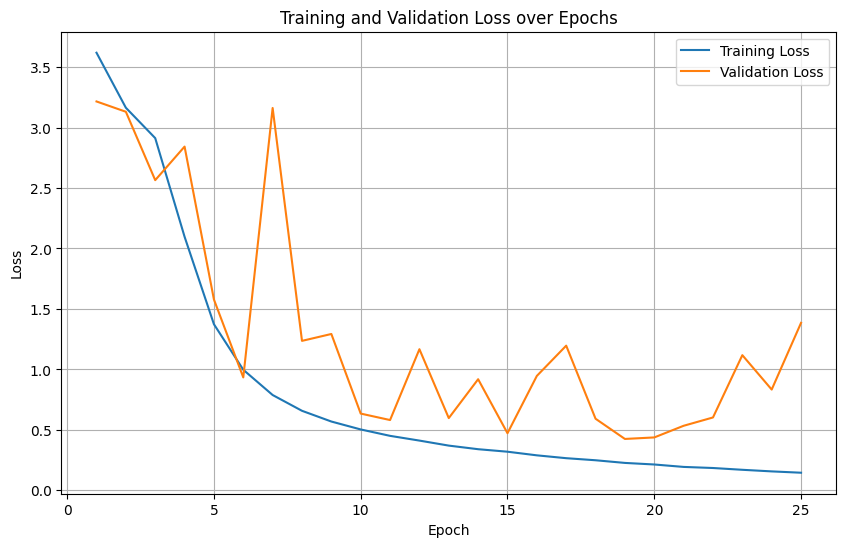

In [22]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Inference

In [23]:
model_path = "./crnn_ctc_pytorch_best.pth" # same as the save_path in train session
data_root = "./"  # same for training
label_file = "./train_data/rec/rec_gt_train.txt" # path to rec_gt_test.txt

In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.2 MB/s eta 0:00:00


In [24]:
import os
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from typing import List
from jiwer import cer, wer

def run_inference(
    model_path: str,
    data_root: str,
    label_file: str,
    batch_size: int = 32,
    output_file: str = "inference_results.txt"
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Build vocabulary
    char2idx, idx2char = build_vocab(label_file)
    test_dataset = HandwritingDataset(data_root, label_file, char2idx)

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda b: pad_collate(b, len(char2idx), 2 * 2 * 1),
        num_workers=os.cpu_count(),
        pin_memory=True,
    )

    # Load model
    model = CRNN(num_classes=len(char2idx))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    predictions: List[str] = []
    ground_truths: List[str] = []

    with torch.no_grad():
        for images, labels, input_lens, label_lens in test_loader:
            images = images.to(device)
            input_lens = input_lens.to(device)

            # Predict
            pred_texts = greedy_decode(model, images, input_lens, idx2char)
            true_texts = [
                "".join(idx2char.get(int(i), "") for i in lbl[:ll])
                for lbl, ll in zip(labels, label_lens)
            ]

            predictions.extend(pred_texts)
            ground_truths.extend(true_texts)

    # Save results
    with open(output_file, "w", encoding="utf-8") as f:
        for gt, pred in zip(ground_truths, predictions):
            f.write(f"GT:\t{gt}\nPR:\t{pred}\n\n")

    # Compute CER and WER
    cer_score = cer(ground_truths, predictions)
    wer_score = wer(ground_truths, predictions)

    print(f"\nInference complete. Results saved to {output_file}")
    print(f"Character Error Rate (CER): {cer_score:.4f}")
    print(f"Word Error Rate (WER):     {wer_score:.4f}")


In [25]:
run_inference(
        model_path=model_path,
        data_root=data_root,  # absolute path to train_data directory
        label_file=label_file,  # absolute path to train_data/rec/rec_gt_test.txt
    )

/tmp/ipykernel_3607977/1707222199.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



Inference complete. Results saved to inference_results.txt
Character Error Rate (CER): 0.2690
Word Error Rate (WER):     0.8251


# Visualization Only

In [26]:
model_path = "./crnn_ctc_pytorch_best.pth" # same as the save_path in train session
data_root = "./"  # same for training
label_file = "./train_data/rec/rec_gt_train.txt" # path to rec_gt_test.txt

n_plots = 10 # number of visualization samples

In [31]:
import os
from pathlib import Path
import torch
from torch.utils.data import DataLoader, Dataset
from typing import List
from jiwer import cer, wer  # <-- added here
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import math
import torch.nn as nn
import torch.nn.functional as F

class HandwritingDataset(Dataset):
    """Loads (image, transcription) pairs listed in a TSV file.

    Each line in *label_file* should be:  <img_rel_path>\t<label>\n
    Images are resized to fixed *target_height* while preserving aspect ratio.
    """

    def __init__(
        self,
        data_root: str | Path,
        label_file: str | Path,
        char2idx: dict[str, int],
        target_height: int = 64,
    ) -> None:
        super().__init__()
        self.data_root = Path(data_root)
        self.samples: List[Tuple[Path, str]] = []
        with open(label_file, "r", encoding="utf-8") as f:
            for line in f:
                img_rel, label = line.rstrip("\n").split("\t", 1)
                self.samples.append((self.data_root / img_rel, label))
        self.char2idx = char2idx
        self.blank_idx = len(char2idx)  # final slot reserved for blank
        self.to_tensor = transforms.ToTensor()  # converts HWC [0,255] -> CHW [0,1]
        self.target_height = target_height

    def _text_to_indices(self, text: str) -> List[int]:
        # Replace '|' with space (same logic as TF script)
        return [self.char2idx.get(ch, self.blank_idx) for ch in text.replace("|", " ")]

    def _resize_keep_ratio(self, img: Image.Image) -> Image.Image:
        if img.height == self.target_height:
            return img
        ratio = self.target_height / img.height
        new_w = max(1, int(img.width * ratio))
        return img.resize((new_w, self.target_height), Image.Resampling.LANCZOS)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("L")  # grayscale
        img = self._resize_keep_ratio(img)
        img_tensor = self.to_tensor(img)  # (1, H, W) float32 in [0,1]
        seq = torch.tensor(self._text_to_indices(label), dtype=torch.long)
        return img_tensor, seq, str(img_path)

def pad_collate(batch, blank_idx: int, downsample_factor: int):
    """Pads images & labels in a batch, returning tensors required by CTC."""
    imgs, labels, paths = zip(*batch)

    # --- pad images to max width ---
    heights = [im.shape[1] for im in imgs]
    assert len(set(heights)) == 1, "all images must share the target height"
    max_w = max(im.shape[2] for im in imgs)
    padded_imgs = []
    for im in imgs:
        pad_w = max_w - im.shape[2]
        padded = F.pad(im, (0, pad_w, 0, 0), value=1.0)  # right‑pad with white
        padded_imgs.append(padded)
    image_batch = torch.stack(padded_imgs)  # (B, 1, H, W)

    # --- pad label sequences ---
    label_lens = torch.tensor([len(l) for l in labels], dtype=torch.long)
    max_lab = max(label_lens)
    padded_labels = torch.full((len(labels), max_lab), blank_idx, dtype=torch.long)
    for i, seq in enumerate(labels):
        padded_labels[i, : len(seq)] = seq

    # CTC expects (T, B, C); we also need input_lengths after CNN down‑sampling
    input_lens = torch.full(
        (len(labels),),
        fill_value=math.floor(max_w / downsample_factor),
        dtype=torch.long,
    )

    return image_batch, padded_labels, input_lens, label_lens, paths

def run_inference(
    model_path: str,
    data_root: str,
    label_file: str,
    batch_size: int = 32,
    output_file: str = "inference_results.txt"
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Build vocabulary
    char2idx, idx2char = build_vocab(label_file)
    test_dataset = HandwritingDataset(data_root, label_file, char2idx)

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda b: pad_collate(b, len(char2idx), 2 * 2 * 1),
        num_workers=os.cpu_count(),
        pin_memory=True,
    )

    # Load model
    model = CRNN(num_classes=len(char2idx))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    predictions: List[str] = []
    ground_truths: List[str] = []

    saved = 0
    os.makedirs("output", exist_ok=True)

    with torch.no_grad():
        for images, labels, input_lens, label_lens, paths in test_loader:
            images = images.to(device)
            input_lens = input_lens.to(device)

            pred_texts = greedy_decode(model, images, input_lens, idx2char)
            true_texts = [
                "".join(idx2char.get(int(i), "") for i in lbl[:ll])
                for lbl, ll in zip(labels, label_lens)
            ]

            predictions.extend(pred_texts)
            ground_truths.extend(true_texts)

            for path, gt, pred in zip(paths, true_texts, pred_texts):
                if saved >= n_plots:
                    break

                # Load image
                img = Image.open(path).convert("L")

                # Create plot
                plt.figure(figsize=(8, 3))
                plt.imshow(img, cmap="gray")
                plt.title(f"GT: {gt}\nPR: {pred}")
                plt.axis("off")

                # Use relative path name for the image
                fname = os.path.basename(path).replace("/", "_")
                save_path = os.path.join("output", f"pred_{fname}.png")
                plt.savefig(save_path, bbox_inches="tight")
                plt.show()
                plt.close()

                saved += 1
            if saved >= n_plots:
                break

    # Save results
    # with open(output_file, "w", encoding="utf-8") as f:
    #     for gt, pred in zip(ground_truths, predictions):
    #         f.write(f"GT:\t{gt}\nPR:\t{pred}\n\n")

    # Compute CER and WER
    # cer_score = cer(ground_truths, predictions)
    # wer_score = wer(ground_truths, predictions)

    # print(f"\nInference complete. Results saved to {output_file}")
    # print(f"Character Error Rate (CER): {cer_score:.4f}")
    # print(f"Word Error Rate (WER):     {wer_score:.4f}")


/tmp/ipykernel_3607977/2804502902.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


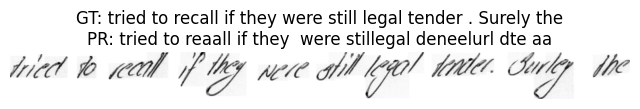

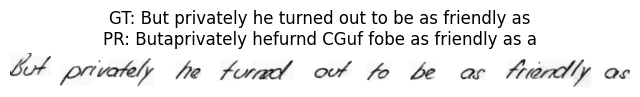

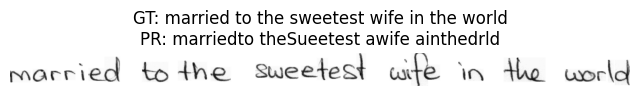

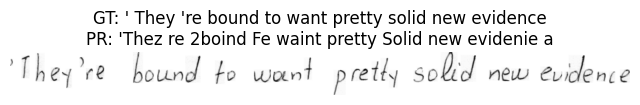

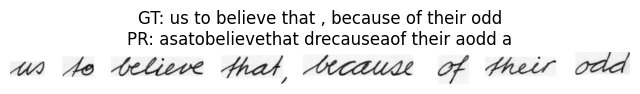

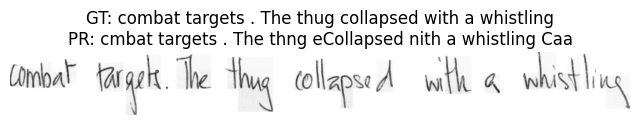

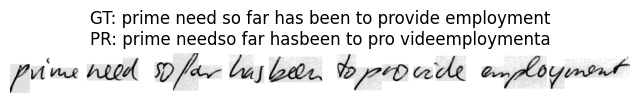

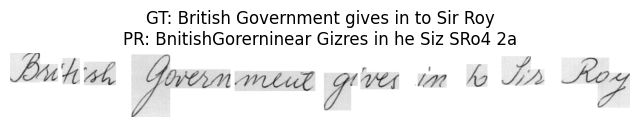

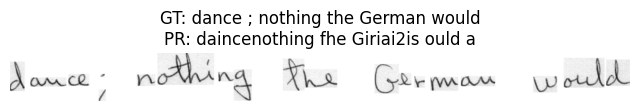

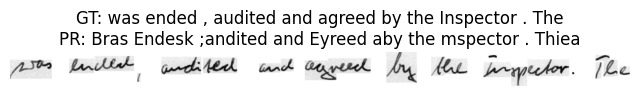

In [32]:
run_inference(
        model_path=model_path,
        data_root=data_root,  # absolute path to train_data directory
        label_file=label_file,  # absolute path to train_data/rec/rec_gt_test.txt
)
